## Часть 6. Линейная Алгебра и Машинное Обучение  

Хорошее знание линейной алгебры очень важно в современном машинном обучении. В этом задании Вам предлагается реализовать метод машинного обучения применив знания матричного дифференцирования и итерационных методов решения систем уравнений :) 

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов, $+1$ или $-1$ для каждого объекта) является логистическая регрессия. Она выводится из метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

Здесь $X$ - матрица объекты-признаки для обучающей выборки (по строкам объекты, по столбцам признаки), а $y$ - вектор ответов. Коэффициент $C$, вообще говоря, нужно подбирать отдельно, поскольку разные его значения приводят к разным решениям задачи оптимизации. Но так как это уже никакого отношения не имеет к линейной алгебре, то в этой задаче мы положим $\mathbf{C = 1}$

Когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

План у нас такой:
- Вычислить градиент функции $L$, эффективно запрограммировать и проверить себя
- Вычислить гессиан функции $L$,  эффективно запрограммировать и проверить себя
- Воспользоваться методом второго порядка для оптимизации 
- Внутри метода оптимизации вместо обращения матрицы, решать систему уравнений с помощью итерационного метода
- Исследовать эффективность различных методов решения системы уравнений на реальных данных

In [238]:
import numpy as np
import scipy.linalg as sla
import scipy.sparse as sps
import scipy.sparse.linalg as spla
from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

Для тестирования правильности вычисления сгенерируем аргументы небольшого размера

In [239]:
w, X, y = np.random.random(10), np.random.random((11, 10)), 2*(np.random.randint(0, 2, 11)-0.5)

**Задача 6.0 (0,5 балла)**

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(-(·)))`.

In [240]:
def logistic(w, X, y):
    '''
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        funcw: np.float 
    '''
    #print np.dot(X, w)
    #np.sum(np.log(1 + np.exp(-y * np.dot(X, w)))) + 0.5 * np.sum(w * w)
    funcw = np.sum(np.logaddexp(0, -y * np.dot(X, w))) + 0.5 * np.sum(w * w)
    return funcw

In [241]:
from sklearn.metrics import log_loss
print logistic(w, X, y)
#print log_loss(y, np.dot(X, w)) 

10.8756206865


**Задача 6.1 (1 балл)**

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций

$\nabla_w L(w, X, y) = \sum_{i = 0}^{N} y_ix_i *exp(-y_ix_iw) * (\frac{1}{(1 + exp(-y_ix_iw))})   - С w$


Эффективно запрограммируйте вычисление градиента (опять же, только матричные операции!)

Обратите внимание на то, что для разреженных матриц понадобится написать немного другой код.

In [242]:
def logistic_grad(w, X, y):
    '''
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    '''
    if sps.issparse(X):
        gradw = np.zeros(w.shape[0]) # Вычислите градиент функции dL/dw
    else:
        gradw = -np.dot(X.T, y * np.exp(-y * np.dot(X, w)) / (1 + np.exp(-y * np.dot(X, w)))) + w
    return gradw

In [243]:
assert(logistic_grad(w, X, y).shape == w.shape)

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей. 

$$[\nabla f(x)]_i \approx \frac{f(x + \epsilon \cdot e_i) - f(x)}{\epsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

Ваша функция должна корректно работать хотя бы с обыкновенными (не разреженными матрицами)

In [244]:
def max_error(a, b): 
    return np.max(np.abs(a-b))

def grad_finite_diff(func, w, eps=1e-8):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w), np.zeros_like(w)

    for i in range(w.size):
        ei = np.array([bool(j == i) for j in range(w.size)], dtype = np.float)
        dnum[i] = (func(w + eps * ei) - func(w)) / eps
    return dnum

In [245]:
mat_grad = logistic_grad(w, X, y)
num_grad = grad_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)
print'err = ', err, 'ok' if err < 1e-6 else 'large error'

err =  1.91754482293e-07 ok


**Задача 6.2 (1 балл)**

Для некоторых задач оптимизации очень удобно использовать гессиан. 

Вычислите гессиан для функции L, запишите ответ в терминах матричных операций. 

**Упражнение**: Можно ли что-то сказать про знакоопределенность этой матрицы?

$$ (Hessian L(w, X, y)) = -((\sum_{i = 0}^{N} x^{T} x \frac{exp^{wxy}}{(\exp^{wxy} + 1) ^{2}})- E) $$


Эффективно запрограммируйте вычисление гессиана. Не забудьте написать отдельную рутину для разреженных матриц.

In [246]:
def sigmoid(w, X, y):
    return 1. / (1 + np.exp(-y * np.dot(w, X)))

def logistic_hess(w, X, y):
    '''
        logistic_hess(w, X, y) вычисляет гессиан функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        hessw: np.array размера (M, M)
    '''
    hessw = np.zeros((w.shape[0], w.shape[0]))
    #x = np.matrix(X[0])
    #print hessw.shape, np.dot(x.T, x).shape
    for i in range(len(X)):
        x = np.matrix(X[i])
        hessw -= (np.exp(y[i] * np.dot(w, X[i])) / ((np.exp(y[i]*np.dot(w, X[i])) + 1) ** 2)) * np.dot(x.T, x)
        
    #print hessw
    #print hessw == hessw.T
    #print np.identity(w.shape[0])
    return -(hessw - np.identity(w.shape[0]))

In [247]:
assert(logistic_hess(w, X, y).shape == (w.shape[0], w.shape[0]))

Теперь проверим правильность реализации подсчёта гессиана

Для гессиана проверка выглядит похожим образом

$$[\nabla^2 f(x)]_{ij} \approx \frac{f(x + \epsilon \cdot e_i + \epsilon \cdot e_j) -f(x + \epsilon \cdot e_i) - f(x + \epsilon \cdot e_j)+ f(x)}{\epsilon^2}~~~~~~~~~~~~~~~~~~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-5}$

In [248]:
def hess_finite_diff(func, w, eps=1e-5):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w).astype(np.float64), np.zeros((w.size, w.size), dtype=np.float64)
    for i in range(w.shape[0]):
        for j in range(w.shape[0]):
            ei = np.asarray([i == k for k in range(w.shape[0])], dtype = np.float)
            ej = np.asarray([j == k for k in range(w.shape[0])], dtype = np.float)
            #print ei, ej
            dnum[i][j] = (func(w + eps * (ei + ej)) - func(w + eps * ei) - func(w + eps * ej) + func(w)) / (eps * eps) 
    #dnum =  Вычислите численный гессиан d func/dw_iw_j для всех i, j
    #print dnum
    return dnum

In [249]:
mat_grad = logistic_hess(w, X, y)
num_grad = hess_finite_diff(lambda w: logistic(w, X, y), w)
err = max_error(mat_grad, num_grad)

print'err = ', err
print('ok' if max_error(mat_grad, num_grad) < 1e-4 else 'very large error') 

err =  6.27064437183e-05
ok


**Задача 6.3 (3+ баллов)**

Так как наша задача оптимизации оказывается выпуклой (см. упражнение про знакоопределённость Гессиана), её можно эффективно решать методом второго порядка, например, методом Ньютона. Напомним, что в общем виде метод Ньютона для решения уравнения (системы уравнений) $H(z) = 0$ имеет вид

$$z_{k+1} = w_k - \mathbf{\alpha_k}\left(\nabla H(z_k)\right)^{-1}H(z_k)$$

Множитель $a_k$ не вполне каноничен, но его введение может ускорять сходимость.

Решение задачи оптимизации $f(w) \rightarrow \min\limits_w$ сводится к нахождению нулей градиента $\nabla f(w) = 0$. Получаем следующий итеративный процесс:

$$w_{k + 1} = w_k - \alpha_k\left(\nabla^2 f(x_k)\right)^{-1} \cdot \nabla f(x_k) =: w_k - \alpha_k d_k$$

Иными словами, основная идея метода Ньютона -- на шаге $k$ выбрать направление спуска $d_k$ с помощью градиента и гессиана, определить длину шага $\alpha_k$ по направлению $d_k$, и повторять сей процесс до сходимости (в выпуклой задаче можно считать, что это 20 итераций).

В методе Ньютона каждое следующее направление оптимизации выбирается как 

$$d_{k+1} = -(\nabla^2 f(x_k))^{-1} \cdot \nabla f(x_k)$$

но, вот беда, операция поиска обратной матрицы очень дорогая и не устойчивая, поэтому будем искать $d_{k+1}$ как решение системы уравнений

$$\nabla^2 f(x_k) d_{k+1} = -\nabla f(x_k)$$

Первым делом вам нужно будет реализовать метод Ньютона.

*Замечание*: Если вы хорошо реализовали вычисление градиента и гессиана, то в функции `newton` вам не понадобилось отдельно обрабатывать разреженные матрицы.

In [250]:
from scipy.optimize.linesearch import line_search_armijo

def newton(func, grad, hess, w0, solver, max_iter=20):
    '''
        func: скалярная функция от вектора размера shape(w0)
        grad: функция вычисляющая градиент функции func
        hess: функция вычисляющая гессиан  функции func
        
        w0: вектор, первая точка в процессе оптимизации 
        solver: функция от двух аргументов A, b находит решение системы Ax=b
        max_iter: количество итераций метода
    '''
    
    x, fvals, ngrads = w0.copy().astype(np.float), [], []

    for iter in range(max_iter):
        fvalx, gradx, hessx = func(x), grad(x), hess(x)
        #lower = sla.cho_factor(hessx)
        #print hessx.shape, grad.shape
        d = solver(hessx, gradx)# Решите систему hess * x = grad 
        
        alpha = 1 / (iter + 2.0)
        x -= alpha * d
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))

    return x, fvals, ngrads

In [251]:
# Пример запуска

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b, tol=1e-2)[0]
cg_  = lambda A, b: spla.cg(A, b, tol=1e-2)[0]

w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_) 

В этом задании вам необходимо в зависимости от метода решения системы уравнений (гаусс, CG, GMRES) исследовать:
- зависимость времени работы метода оптимизации от выбора метода решения системы;
- скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений (параметр `tol`);
- какую часть времени метод тратит на решение системы уравнений и какую на вычисление гессиана и градиента.

Эксперименты нужно провести на нескольких наборах данных. Рассмотрите следующие три ситуации: 
- малое число признаков d < 100
- среднее число признаков d ~ 500 
- большое число признаков d ~ 1000

Мы будем поощрять любые дополнительные исследования, например, если вы попытаетесь проверить статистическую значимость результатов экспериментов: ведь если какой-нибудь метод показал себя лучше в одном-единственном эксперименте, то это ещё ничего не значит.

**Рекомендация**: можете рассмотреть три набора данных, которые можно скачать с сайта [LIBSVM1](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html): **a9a**, **w8a** (много объектов, сравнительно немного признаков) и **colon-cancer** (в нём достаточно мало объектов, но зато гораздо больше признаков).

Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в формате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию [load_svmlight_file](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html) из модуля sklearn.datasets. Эта функция всегда возвращает матрицу X типа sp.sparse.csr_matrix (разреженная марица). В датасете **colon-cancer** матрица X не будет разреженной, поэтому сразу же после вызова функции load_svmlight_file следует привести X к типу np.ndarray. Это можно сделать с помощью команды X = X.toarray().

**Задача 6.4 (0 балов, весь код написан за Вас, но очень красивые картинки)** 

Давайте визуализируем наш метод, а то хочется глазами посмотреть. Просто запустите код:

In [252]:
from scipy import optimize

def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def viz_opt(func, gradf, hessf, X, y, n_iter=10):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    w, d = np.zeros(X.shape[1]), np.zeros(X.shape[1])
    
    for i in range(n_iter):        
        loss1[i] += func(w)
        visualize(X, y, w, loss1, n_iter)
        
        fvalx, gradx, hessx = func(w), grad(w), hess(w)
        d = cg(hessx, -gradx)[0]
        alpha = line_search_armijo(func, w, d, gradx, fvalx)[0]
        w += alpha*d
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    plt.show()

In [253]:
from sklearn.datasets import make_moons, make_circles, make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

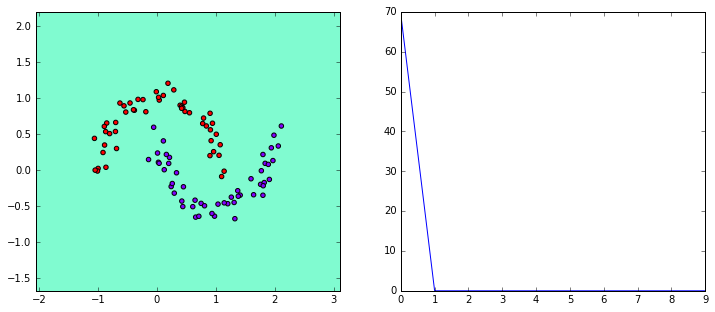

NameError: global name 'cg' is not defined

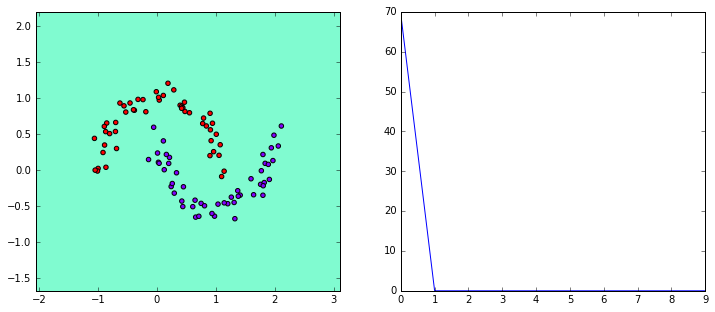

In [254]:
from IPython import display

def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(-X.dot(w))) - 0.5)

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(func, grad, hess, X, y) 